In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse

def str_url_format(word):
    return (urllib.parse.unquote(word)
                .replace("_", " ")
                .strip())
    
# Graph is defined in file `links.tsv`
df = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/links.tsv", 
                  skiprows=12, 
                  sep="\t", 
                  header=None)
      .applymap(str_url_format)
      .applymap(str.strip)
      .rename(columns={0:"out",
                       1:"in"})
     )

df.sample(5)

,out,in
9406,Art,Aesthetics
61802,La Grande Armée,British Isles
52704,Human,Weapon
60614,Kazakhstan,Persian Empire
6466,Ancient Greece,Roman Greece


In [114]:
# Describe df

print(f"There are {df.shape[0]} edges")
print(f"connecting {df.stack().nunique()} unique nodes in the network.")
print(f"\n\t * {df['out'].nunique()} nodes have out-links.")
print(f"\t * {df['in'].nunique()} nodes have in-links.\n")

print(f"This means {df.stack().nunique() - df['out'].nunique()} nodes are dead-ends (no out-links),")
print(f"and {df.stack().nunique() - df['in'].nunique()} \
nodes can never be reached from any other article (no in-links) ☠️")

There are 119882 edges
connecting 4592 unique nodes in the network.

	 * 4587 nodes have out-links.
	 * 4135 nodes have in-links.

This means 5 nodes are dead-ends (no out-links),
and 457 nodes can never be reached from any other article (no in-links) ☠️


In [115]:
# nodes with no outlink (dead-ends)
nodes_no_outlink = (set(df.stack()
                        .unique())
                    .difference(df['out']
                                .unique()))
print(len(nodes_no_outlink))
nodes_no_outlink

5


{'Directdebit',
 'Duchenne muscular dystrophy',
 "Klinefelter's syndrome",
 'Local community',
 'Osteomalacia'}

In [116]:
# Let's see which articles can't be reached from any other
nodes_no_inlink = list((set(df.stack()
                            .unique())
                        .difference(df['in']
                                    .unique())))
print(len(nodes_no_inlink))

nodes_no_inlink[:5]

457


['Kipchaks in Georgia',
 'Project MKULTRA',
 'Winfield Scott (ship)',
 'Btrieve',
 'Terik']

### All these nodes can only be visited if they're selected as starting point.

---

In [117]:
freq_out = df['out'].value_counts()
freq_in = df['in'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='outer')
               .fillna(0))

degree_freq.head()

,in,out
1 Ceres,12.0,32.0
10th century,65.0,26.0
11th century,57.0,48.0
12th century,85.0,45.0
13th century,84.0,34.0


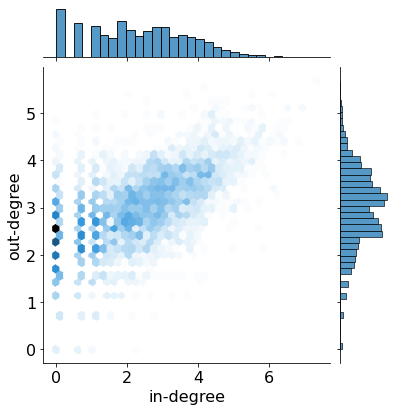

In [123]:
plot_deg = degree_freq[~(degree_freq==0).any(axis=1)]


g = sns.jointplot(data=np.log(plot_deg), 
                  x="in", y="out", 
                  kind='hex')

g.ax_joint.set_xlabel("in-degree")
g.ax_joint.set_ylabel("out-degree");

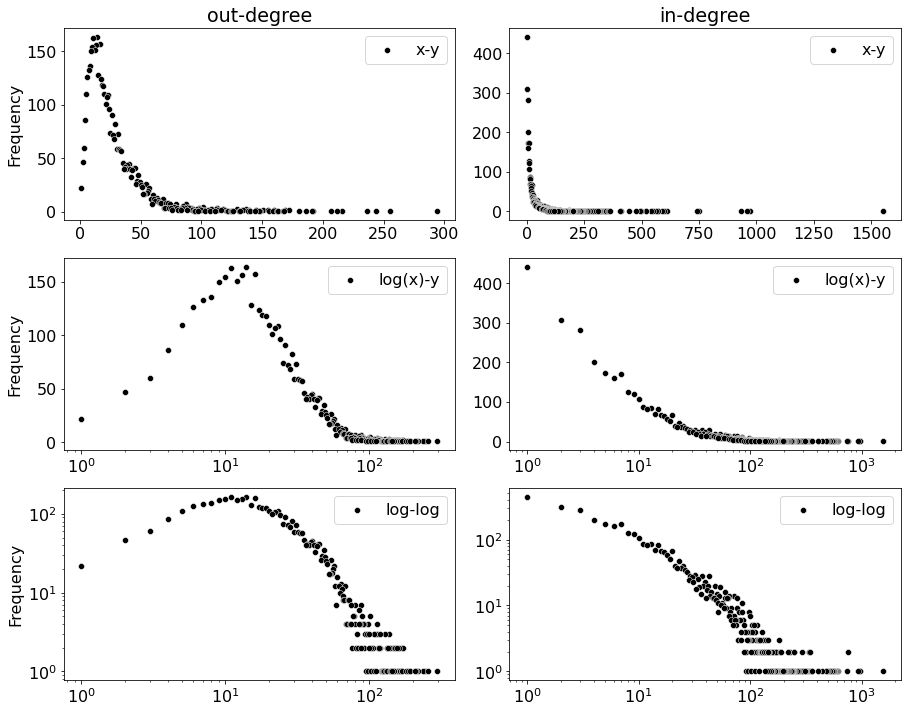

In [124]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,2,
                       figsize=(15,12),
                       gridspec_kw={'wspace':0.14})

labels = ["x-y", "log(x)-y", "log-log"]
for i in range(3):
    sns.scatterplot(data = df['out'].value_counts().value_counts(), 
                    ax=ax[i,0], color='k', label=labels[i])
    sns.scatterplot(data = df['in'].value_counts().value_counts(), 
                    ax=ax[i,1], color='k', label=labels[i])

ax[0, 0].set_title("out-degree")
ax[0, 1].set_title("in-degree")

for i in range(2):
    # Set log scale in x for second row plots
    ax[1,i].set_xscale('log')
    # log-log scale in 3rd row
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    
for i in range(3):
    ax[i, 0].set_ylabel("Frequency")
    ax[i, 1].set_ylabel("")
    
plt.legend();

### Distributions of in- and out- degree are very different.

- in-degree distribution is more power-law-like. The lowest the in-degree, the higher frequency.
- out-degree has a more likely value of around 15. 

# TODO

- Distribution of in-links and out-links per node
- Test hypothesis: visit frequency correlates with node in-degree.

In [125]:
# Ukraine_A is not in this df (meaning no link points to it)
degree_freq[degree_freq.index.str.startswith("Ukraine")]

,in,out
Ukraine,171.0,58.0


# Load actual paths. Check frequency

In [126]:
def split_decode_path(path):
    pathl = (path.replace("_", " ")
             .strip()
             .split(";"))
    return list(map(
        urllib.parse.unquote, 
        pathl
    ))

df_paths_success = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: str_url_format(x).split(";")[-1]))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
17683,4f9891953951c40f,1298836409,100,Glass;Biology;Ecology;Climate;Tropical_cyclone...,NaN,Hurricane Epsilon (2005),win,"[Glass, Biology, Ecology, Climate, Tropical cy...",Glass
1646,0dc49fcd7b52ef51,1348004396,83,Batman;Earthquake;Earth;Plant;Tree;Wood,NaN,Wood,win,"[Batman, Earthquake, Earth, Plant, Tree, Wood]",Batman
13513,092025d81d682059,1247972253,51,Glacier;Precambrian;Cambrian_explosion;The_Ori...,1.0,The Origin of Species,win,"[Glacier, Precambrian, Cambrian explosion, The...",Glacier
47114,0f37ccba7e55e4e5,1309615693,35,Soil_structure;Garden;Plant;Herbivore,NaN,Herbivore,win,"[Soil structure, Garden, Plant, Herbivore]",Soil structure
21047,746641ff49cd4008,1327285578,576,Eukaryote;Organism;Human;Conflict;War;Invasion...,5.0,Battle of the Eastern Solomons,win,"[Eukaryote, Organism, Human, Conflict, War, In...",Eukaryote


# Selection of starting and target nodes

Check whether it's uniformly distributed.
- does `use as start` correlate with out-degree of node?
- does `use as target` correlate with in-degree of node?

In [156]:
from itertools import chain


pd.Series(list(chain(*df_paths["pathl"].values))).value_counts()

<                             33468
United States                 12449
Europe                         5611
United Kingdom                 5328
England                        4558
                              ...  
Colditz Castle                    1
Portuguese Communist Party        1
Comet White-Ortiz-Bolelli         1
Baby Gender Mentor                1
Architecture of Windows NT        1
Length: 4183, dtype: int64

In [158]:
# Merge all dfs that count node properties:
# in-degree, out-degree, use as start, use as target
degree_connect = (
    pd.merge(
        degree_freq,
        # Count how many times an article was used as target
        df_paths["target"].value_counts(),
        left_index=True,
        right_index=True,
        how="outer"
    )
    .merge(
        # Count how many times an article was used as starting point
        df_paths["start"].value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
    .merge(
        # Count how many times an article was clicked
        pd.Series(
            list(chain(*df_paths["pathl"].values)), 
            name="clicks"
        )
        .value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
)

degree_connect

,in,out,target,start,clicks
1 Ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
Åland,0.0,19.0,NaN,NaN,4.0
Édouard Manet,0.0,20.0,NaN,NaN,7.0
Éire,0.0,8.0,NaN,NaN,13.0
Óengus I of the Picts,0.0,10.0,NaN,NaN,NaN


In [168]:
np.log(degree_connect).corr()

/opt/anaconda3/envs/ada-project/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,in,out,target,start,clicks
in,1.000000,0.587444,0.500900,0.358023,0.779021
out,0.587444,1.000000,0.309369,0.238799,0.463741
target,0.500900,0.309369,1.000000,0.465963,0.671760
start,0.358023,0.238799,0.465963,1.000000,0.705860
clicks,0.779021,0.463741,0.671760,0.705860,1.000000


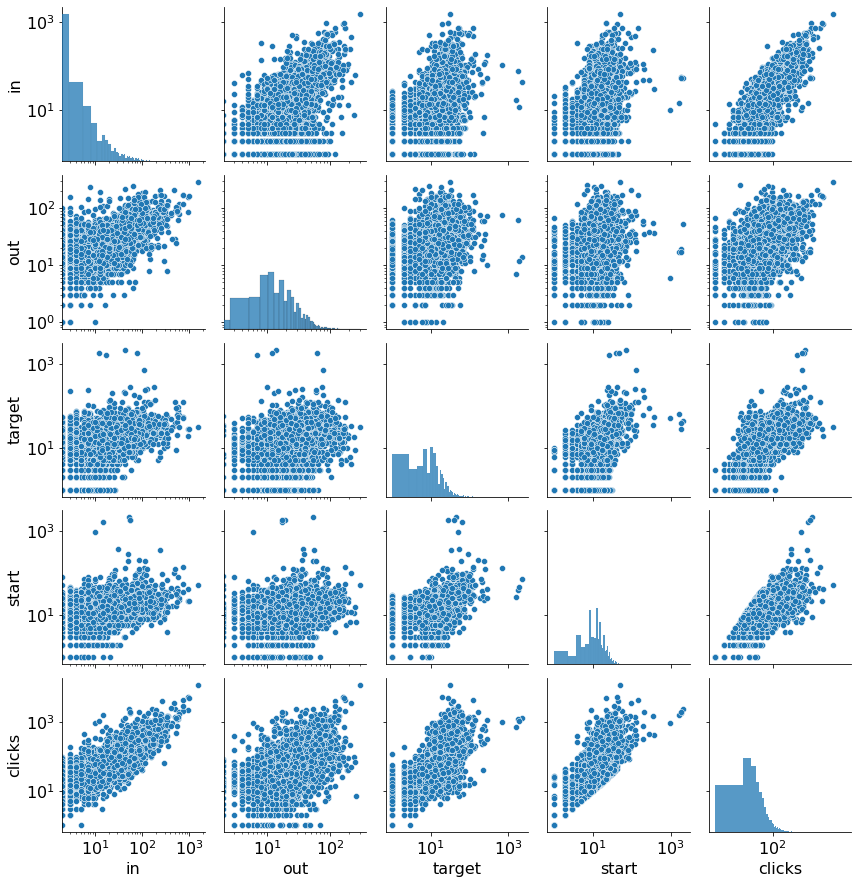

In [164]:
pp = sns.pairplot(degree_connect)

for ax in pp.axes.flat:
    ax.set(xscale="log", yscale="log")

# Idea:

Analyze paths by measuring the curvature of the nodes it goes through.

- Do successful paths tend to go through highly connected nodes? (we can test this statistically!)

- Can we come up with a different classification? (based on how curvature plot looks like).

TODO: Normalize x axis from 0 to 1, plot a few paths.

### Some articles are set as target, but are not in the graph:
Sources are: 
- misspelling (Adolf/Adolph) (Bogota/Bogotá)
- they are just not in the graph

### <font color="red"> This happens only rarely, so we'll remove these cases. </font>

In [144]:
degree_connect[degree_connect[["in","out"]].isna().any(axis=1)]

,in,out,target,start
Adolph Hitler,NaN,NaN,1.0,NaN
Black ops 2,NaN,NaN,1.0,NaN
Bogota,NaN,NaN,1.0,NaN
Charlottes web,NaN,NaN,1.0,NaN
Christmas,NaN,NaN,5.0,NaN
English,NaN,NaN,1.0,NaN
Fats,NaN,NaN,1.0,NaN
Georgia,NaN,NaN,1.0,NaN
Great,NaN,NaN,1.0,NaN
Kashmir,NaN,NaN,1.0,NaN
